*Unresolved Question*
1. What is the significance of `base model accuracy slightly more than 50%` in ensemble learning?
2. What `sampling techniques` are employed in ensemble models to reduce the variance by not increasing the bias? ✓
3. What are the key differences between `homogeneous ensembles (Random Forest)` and `heterogeneous ensembles (Voting Classifier)` in terms of `Variance Reduction?` ✓
4. How do ensemble methods (Voting and Averaging) achieve the `balance between reducing prediction variance while maintaining low bias?` ✓
---

### **What is a Voting Ensemble?**

A **Voting Ensemble** (or "Majority Rule" ensemble) is a meta-classifier that combines the predictions from multiple independent machine learning models. It aggregates the individual predictions of these **base estimators** (which can be the same or different algorithms) to arrive at a final prediction.

The core idea is that a group of "weak" or "specialized" learners can make a more accurate and robust collective decision than any single model, much like a committee or a jury.

In [ ]:
# Importing necessary libraries
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
# Loading the dataset
dataset = load_iris(as_frame=True)
df = pd.DataFrame(dataset.data)
df['Species'] = dataset.target
new_df = df[df['Species'] != 0][['sepal length (cm)', 'petal width (cm)', 'Species']]

X = new_df[['sepal length (cm)', 'petal width (cm)']]
y = new_df['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

new_df.head()

,sepal length (cm),petal width (cm),Species
50,7.0,1.4,1
51,6.4,1.5,1
52,6.9,1.5,1
53,5.5,1.3,1
54,6.5,1.5,1


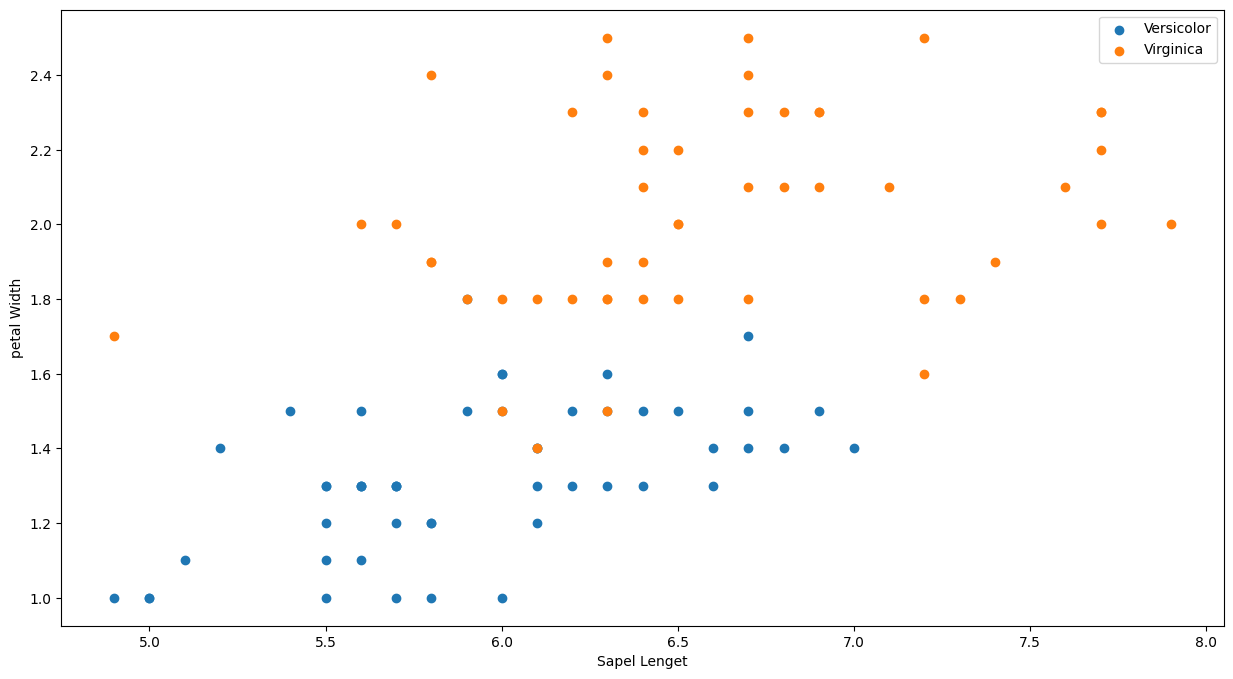

In [ ]:
# Visualizing the data
plt.figure(figsize=(15,8))
plt.scatter(new_df[new_df['Species'] == 1]['sepal length (cm)'], new_df[new_df['Species'] == 1]['petal width (cm)'], label = 'Versicolor')
plt.scatter(new_df[new_df['Species'] == 2]['sepal length (cm)'], new_df[new_df['Species'] == 2]['petal width (cm)'], label = 'Virginica')
plt.legend()
plt.xlabel('Sapel Lenget')
plt.ylabel('petal Width')
plt.show()

In [ ]:
# Base Models
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=2)
svc = SVC()
rf = RandomForestClassifier()

# List of models
estimators = [lr, dt, svc, rf]

# Iterate over each estimator, fit, and evaluate
for estimator in estimators:
    cvs = cross_val_score(estimator, X, y, cv=10, scoring='f1').mean()
    print(f"{estimator.__class__.__name__}: F1 Score = {cvs.round(2)}")

LogisticRegression: F1 Score = 0.93
DecisionTreeClassifier: F1 Score = 0.93
SVC: F1 Score = 0.92
RandomForestClassifier: F1 Score = 0.9


#### **Hard Voting (Majority Voting)**

In hard voting, every base model in the ensemble **votes** for a class (e.g., Class A, Class B, or Class C). The final prediction is the class that receives the **majority of the votes**.

*   **Mechanism**: Each classifier gets one vote per prediction. The class with the most votes wins.
*   **Analogy**: A committee of experts takes a show-of-hands vote.
*   **Requirement**: Base models must be able to predict a class label.

**Example:**
Imagine an ensemble with 5 different models predicting for a single data point:

| Model 1 | Model 2 | Model 3 | Model 4 | Model 5 | **Final Prediction (Hard Vote)** |
| :---: | :---: | :---: | :---: | :---: | :---: |
| Class A | Class A | Class B | Class A | Class B | **Class A** |

*   Class A gets 3 votes.
*   Class B gets 2 votes.
*   **Result**: `Class A` is the winner.

In [ ]:
# Building Classifer
vlt_clf = VotingClassifier(
    estimators=[
        # Make sure to tune this models befor using them for voting classification
        ('lr', LogisticRegression()),
        ('dt', DecisionTreeClassifier()),
        ('svc', SVC()),
        ('rf', RandomForestClassifier())
    ],
    voting='hard'
)

vlt_clf.fit(X_train, y_train)
# When you fit coting classifier, it clones all the estimators and fits the clones

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('dt', DecisionTreeClassifier()), ('svc', SVC()),
                             ('rf', RandomForestClassifier())])

In [ ]:
# Model Evaluation
y_pred = vlt_clf.predict(X_test)
vlt_clf.score(X_test, y_test)

0.95

In [ ]:
# Cross Validation
cross_val_score(vlt_clf, X, y, cv = 10, scoring='f1').mean()

0.9249494949494949

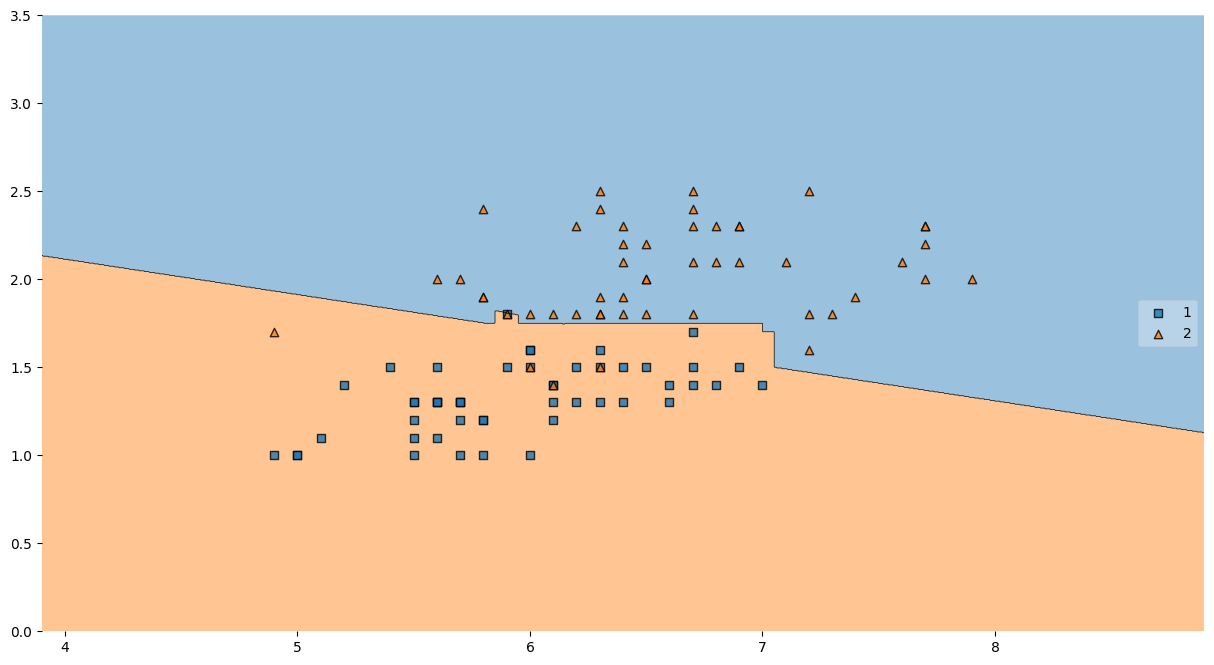

In [ ]:
# Plotting Decision Regions
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 8))
plot_decision_regions(
    X.values, y.values, vlt_clf, legend=5
)
plt.show()

#### **2. Soft Voting (Weighted Average of Probabilities)**

Soft voting is often more powerful but requires base models that can output **predicted probabilities** (e.g., `predict_proba()` in scikit-learn), not just class labels.

*   **Mechanism**: For each class, the predicted probabilities from all classifiers are averaged. The final prediction is the class with the **highest average probability**.
*   **Analogy**: Instead of just voting for a candidate, each expert gives a confidence score (0-100%) for each candidate. The candidate with the highest average confidence score wins.
*   **Benefit**: It incorporates the **certainty** (or uncertainty) of each model, leading to more nuanced and often better performance.

**Example:**
Using the same 5 models, but now we look at their predicted probabilities for Class A and Class B.

| Model | P(Class A) | P(Class B) |
| :--- | :---: | :---: |
| Model 1 | **0.91** | 0.09 |
| Model 2 | **0.90** | 0.10 |
| Model 3 | 0.44 | **0.56** |
| Model 4 | **0.89** | 0.11 |
| Model 5 | 0.40 | **0.60** |
| **Average** | **0.708** | 0.292 |

*   Average probability for `Class A` = (0.91 + 0.90 + 0.44 + 0.89 + 0.40) / 5 = **0.708**
*   Average probability for `Class B` = (0.09 + 0.10 + 0.56 + 0.11 + 0.60) / 5 = **0.292**
*   **Result**: `Class A` is the winner because it has the higher average probability.

**Key Difference:** Notice how Model 3 and Model 5 were not very confident in their prediction for `Class A` (probabilities of 0.44 and 0.40). Soft voting downweights their "vote" compared to the highly confident Model 1 and Model 2. In hard voting, all votes are counted equally.

In [ ]:
# Converting to `Soft Voting`
vlt_clf.voting = "soft"

# Since SVC dont have predict_prob() method, we have to enable the `probability` hyperparameter True
vlt_clf.named_estimators["svc"].probability = True 

# Training and Evaluation
vlt_clf.fit(X_train, y_train)
vlt_clf.score(X_test, y_test)

0.95

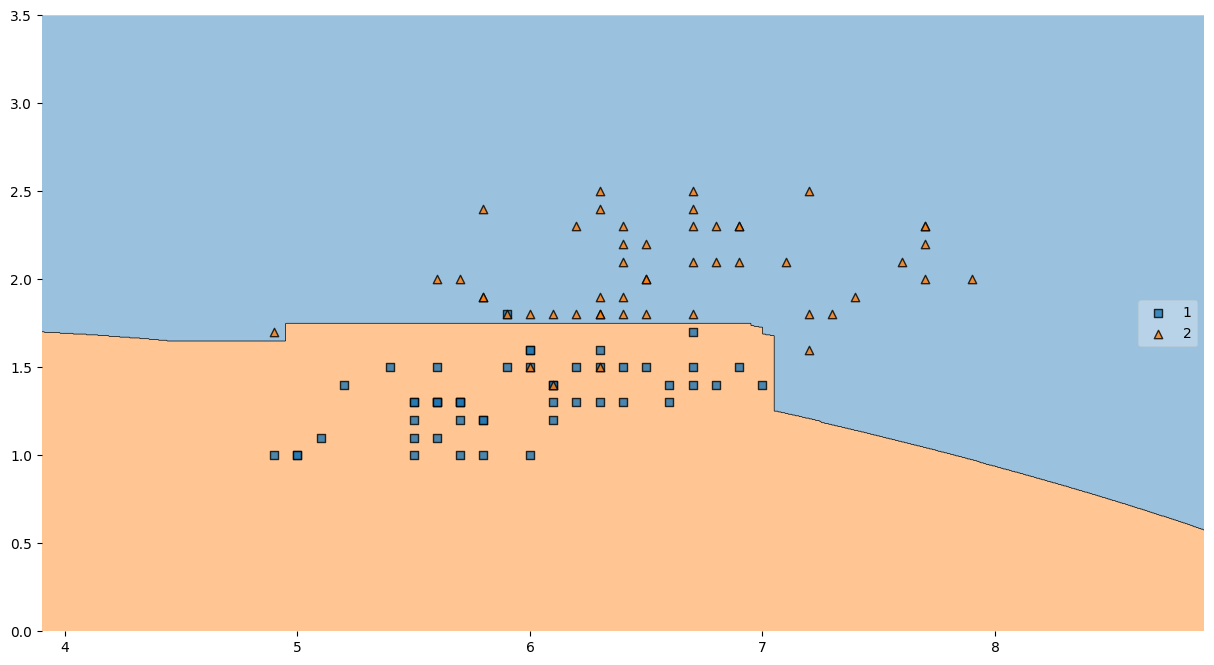

In [ ]:
# Decision Regions
plt.figure(figsize=(15, 8))
plot_decision_regions(
    X.values, y.values, vlt_clf, legend=5
)
plt.show()

### **Important Considerations When Using a Voting Classifier**

To successfully implement a voting ensemble and get the best performance, keep these critical points in mind:

#### 1. Diversity of Base Estimators is Paramount
This is the most important rule. The strength of an ensemble comes from the fact that different models make different types of errors.
*   **What to do**: Use fundamentally different algorithms (e.g., a linear model like Logistic Regression, a tree-based model like Random Forest, and a distance-based model like SVM with an RBF kernel).
*   **What to avoid**: Using five identical models (e.g., five Decision Trees with the same parameters) is pointless. They will all make the same errors, and the vote will be no better than a single model.

#### 2. Base Model Performance is a Prerequisite
You cannot combine weak models that perform at or below chance level and expect a strong ensemble. **Garbage in, garbage out.**
*   **What to do**: Ensure each base model is reasonably strong and better than random guessing on its own. Tune the hyperparameters of each base model individually before putting them into the ensemble.

#### 3. Soft Voting is Generally Preferred (If Possible)
*   **Why**: Soft voting incorporates the confidence of each predictor, which is more informative than a simple binary vote. It almost always performs as well as or better than hard voting.
*   **Constraint**: You can only use soft voting if all your base estimators support the `predict_proba` method. Some models, like SVMs in their default configuration, do not naturally output calibrated probabilities (though `scikit-learn` offers `Platt scaling` via `probability=True` which can help).

#### 4. Weights Can Be Assigned for Imbalanced Influence
Both hard and soft voting support the `weights` parameter. This allows you to give more influence to models you trust more.
*   **Example**: `weights=[3, 1, 2]` means the first model's vote counts 3x, the second counts 1x, and the third counts 2x. This is incredibly useful if one model is significantly more accurate than the others.

#### 5. Computational Cost and Interpretability
*   **Cost**: A voting ensemble requires training and maintaining all base models. The training can be parallelized (as models are independent), but prediction time is linear with the number of models. This might not be suitable for `low-latency applications`.
*   **Interpretability**: The final decision is a combination of many models, making it a `"black box."` It is very hard to explain *why* the ensemble made a particular prediction, which can be a problem in regulated industries.

#### 6. Prefer Stacking for Maximum Performance
While voting is simple and effective, `**Stacking (Stacked Generalization)**` is a more advanced technique that uses another model (a meta-learner) to learn the *best way* to combine the base predictions. If you are after the absolute best performance and are not afraid of added complexity, explore stacking.

---

### **Summary Table**

| Feature | Hard Voting | Soft Voting |
| :--- | :--- | :--- |
| **Input** | Class Labels | Predicted Probabilities |
| **Mechanism** | Majority Rule | Average Probability |
| **Requirement** | `predict()` method | `predict_proba()` method |
| **Performance** | Good | **Generally Better** |
| **Information Use** | Limited (only the label) | Rich (uses model confidence) |